In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
import json
import sys
from typing import Dict, List, Tuple

In [42]:
def safe_eval_formula(formula: str, values_dict: Dict[str, np.ndarray]) -> np.ndarray:
    """Safely evaluate a formula with numpy arrays."""
    def step(x):
        """Step function: 0 if x <= 0, else 1"""
        return np.where(x <= 0, 0, 1)
    
    def safe_max(a, b):
        """Safe max for numpy arrays."""
        return np.maximum(a, b)
    
    def safe_min(a, b):
        """Safe min for numpy arrays."""
        return np.minimum(a, b)
    
    allowed_builtins = {
        'max': safe_max,
        'min': safe_min,
        'abs': np.abs,
        'pow': np.power,
        'sqrt': np.sqrt,
        'exp': np.exp,
        'log': np.log,
        'floor': np.floor,
        'ceil': np.ceil,
        'step': step,
    }
    
    try:
        result = eval(formula, {"__builtins__": allowed_builtins}, values_dict)
        return np.asarray(result, dtype=float)
    except Exception as e:
        print(f"Warning: Formula evaluation failed: {e}", file=sys.stderr)
        return np.full(len(next(iter(values_dict.values()))), np.nan)

In [43]:
# テスト用の JSON を作成
sample_dump = {
    "worker_id": "12345678-1234-1234-1234-123456789012",
    "job_id": "87654321-4321-4321-4321-210987654321",
    "generation": 150,
    "best_error": 0.0234,
    "best_formula": "(x0 - x1) * 1.5",
    "target_formula": "dmg = max(x0 - x1, 1.0) * 1.5",
    "sample_count": 1000,
    "selected_features": ["x0", "x1", "x2"],
    "max_generations": 200,
    "target_error": 0.001,
    "top_candidates": [
        {
            "rank": 1,
            "formula": "(x0 - x1) * 1.5",
            "rmse": 0.0234
        },
        {
            "rank": 2,
            "formula": "(x0 - x1) * 1.4",
            "rmse": 0.0456
        }
    ]
}

# ファイルに保存
with open("test_dump.json", "w") as f:
    json.dump(sample_dump, f, indent=2)

print("✓ test_dump.json created")

✓ test_dump.json created


In [44]:
# JSON ファイルパスを指定（例: "fusou_dump_1704912345.json"）
dump_file = "test_dump.json"  # ← ここを変更してください

# オプション: サンプル数（デフォルト: 200）
n_samples = 200

In [45]:
# JSON ファイルを読み込む
try:
    with open(dump_file, 'r') as f:
        dump_data = json.load(f)
    print(f"✓ Loaded: {dump_file}")
    print(f"  Generation: {dump_data.get('generation', 'N/A')}")
    print(f"  Best Error: {dump_data.get('best_error', 'N/A')}")
    print(f"  Features: {dump_data.get('selected_features', [])}")
except FileNotFoundError:
    print(f"✗ File not found: {dump_file}")
    print("  Creating test data instead...")
    dump_data = sample_dump

✓ Loaded: test_dump.json
  Generation: 150
  Best Error: 0.0234
  Features: ['x0', 'x1', 'x2']


Plotting with features: ['x0', 'x1', 'x2']
Best formula: (x0 - x1) * 1.5
Target formula: dmg = max(x0 - x1, 1.0) * 1.5



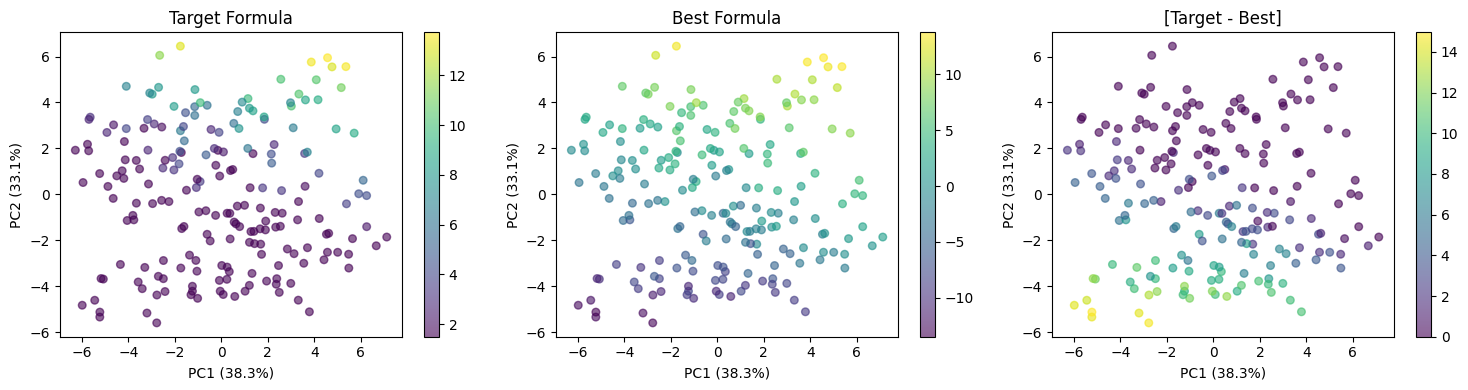

In [46]:
# プロットを実行
plot_results(dump_data, features=dump_data.get('selected_features'), n_samples=n_samples)

# Formula Solver Results Plotter

このノートブックは、`/dump` コマンドで生成された JSON ファイルを読み込み、
データセット・目標式・得られた式を比較するグラフを表示します。

## 使い方
1. TUI で `/dump` コマンドを実行 → `fusou_dump_<TIMESTAMP>.json` が生成される
2. 下のセルを実行してグラフを表示

## グラフの見方

### 概要
表示されるグラフは、**目標となる式（Target Formula）** と **最適化によって得られた式（Best Formula）** の出力値を比較する3パネルの散布図です。

色の濃淡は出力値の大きさを表しており、以下のように解釈します：

### 左パネル：Target Formula（目標式）
- **意味**: あるべき理想的な出力値を示す基準となる式です
- **見方**: 色（色バーの値）が目標式の出力を表します
  - 黄色に近い：出力値が大きい
  - 紫色に近い：出力値が小さい

### 中央パネル：Best Formula（最適化された式）
- **意味**: GA（遺伝的アルゴリズム）によって進化させられ、最も目標式に近づいた式です
- **見方**: 色が最適化式の出力を表します
- **比較のコツ**: 左と中央のパネルを比べると、最適化がどれだけうまくいったかが視覚的にわかります

### 右パネル：[Target - Best]（差分）
- **意味**: 目標式と最適化式の差分（誤差）です
- **見方**: 
  - 黄色に近い：目標式の方が大きく、最適化式が不足している
  - 紫色に近い：最適化式の方が大きく、目標式より過剰である
  - 色が薄い（ニュートラル）：誤差が小さい（最適化がうまくいっている）

### グラフの種類

#### 1次元データ（特徴量が1個）
- **軸**: X軸=特徴量、Y軸=式の出力値
- **形状**: 3つの散布図が横並び

#### 2次元データ（特徴量が2個）
- **軸**: X軸=1番目の特徴量、Y軸=2番目の特徴量
- **色**: 式の出力値
- **形状**: 3つの散布図が横並び

#### 3次元以上のデータ（特徴量が3個以上）
- **軸**: PC1, PC2 （主成分分析で2次元に圧縮した軸）
- **色**: 式の出力値
- **解釈**: 複数の特徴量の関係を2次元平面に投影したもの
- **軸ラベル**: 「PC1 (XX%)」のような形式で、各主成分がデータの何%の分散を説明しているかを表示

### 解釈のポイント

✅ **最適化がうまくいっている場合**
- 左と中央のパネルの色分布がほぼ同じ
- 右パネルが薄い色（ニュートラル）で統一されている

❌ **最適化が失敗している場合**
- 左と中央のパネルの色分布が大きく異なる
- 右パネルに強い色（黄色や紫色）が目立つ
